# One row per patient model

To keep it simple, to start off with we simply model the patients as a single row, i.e. each feature is a scalar or a categorical variable.

See `03_mortality_red_dataset` notebook for more info.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

establish connection to DB and define helper function for running queries

In [2]:
import pandas as pd
from proto.etl.config import SSHInfoEicu, DBInfoEicu
from proto.etl.utils import connect_to_db_via_ssh, run_eicu_query, get_column_completeness, load_schema_for_modelling

conn = connect_to_db_via_ssh(SSHInfoEicu, DBInfoEicu)
cursor = conn.cursor()
query_schema = 'set search_path to eicu_crd;'

#### Load data, get target variable

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, BatchNormalization, SpatialDropout1D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [87]:
# load vars
df = pd.read_csv('orpp_all.csv').set_index('patientunitstayid')

# load targets
query = """
select p.patientunitstayid, i.hosp_mort, icu_los_hours
from patient_top5hospitals_mort_dataset p
inner join icustay_detail i
on p.patientunitstayid=i.patientunitstayid
"""
df_y = run_eicu_query(query, conn).set_index('patientunitstayid')

# there are 100 missing mortality labels, we impute them with zero
#re-order y vars to match the order of X
df_y.fillna(0, inplace=True)
df_y = df_y.loc[df.index]
df_y.to_csv('mort_y.csv')

#### Setup encoders for the categorical input vars

In [88]:
cat_encoders = {
    'ethnicity': LabelEncoder(),
    'hospital_region': LabelEncoder(),
    'unittype': LabelEncoder(),
    'apachedxgroup': LabelEncoder()
}
for col, label_encoder in cat_encoders.items():
    df[col] = label_encoder.fit_transform(df[col])

#### Normalise numeric input features

In [90]:
cat_vars = [
    'ethnicity',
    'hospital_region',
    'unittype',
    'apachedxgroup'
]
num_cols = list(df.columns[4:].values)

# we don't want to scale the embed dims
embed_dims = 100
num_cols_to_scale = num_cols[:-embed_dims]
scaler = RobustScaler(quantile_range=(10.0, 90.0))
# scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols].values)

#### Setup training/test data

In [91]:
# do train-test split without scikit to keep the data with its col names - see later
np.random.seed(42)
test_ratio = 0.1
train_ix = np.random.rand(len(df)) < 1 - test_ratio

# define X and y, then split it into train (90%) and test (10%)
X = df.values
y = df_y['hosp_mort'].values
df_X_train = df[train_ix]
y_train = y[train_ix]
df_X_test = df[~train_ix]
y_test = y[~train_ix]

In [96]:
def get_data_dict(df, num_cols):
    return {
        'ethnicity': np.array(df.ethnicity),
        'hospital_region': np.array(df.hospital_region),
        'unittype': np.array(df.unittype),
        'apachedxgroup': np.array(df.apachedxgroup),
        'num_cols': df[num_cols].values
    }
X_train = get_data_dict(df_X_train, num_cols)
X_test = get_data_dict(df_X_test, num_cols)  

#### Define basic FFN model and its hyperparams

In [100]:
EMBED_SIZE = 5
DENSE_SIZE = 1024
BATCH_SIZE = 256
EPOCHS = 50
DROPOUT = 0.5
STEPS = int(len(X_train) / BATCH_SIZE) * EPOCHS

# set up decaying learning rate for Adam
LR_INIT, LR_FIN = 0.001, 0.0001
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
lr_decay = exp_decay(LR_INIT, LR_FIN, STEPS)
optimizer_adam = Adam(lr=0.001, decay=lr_decay, amsgrad=True)

In [101]:
# cat features embedded
in_et = Input(shape=(1,), name='ethnicity')
emb_et = Embedding(cat_encoders['ethnicity'].classes_.shape[0], 2)(in_et)
in_hr = Input(shape=(1,), name='hospital_region')
emb_hr = Embedding(cat_encoders['hospital_region'].classes_.shape[0], 2)(in_hr)
in_ut = Input(shape=(1,), name='unittype')
emb_ut = Embedding(cat_encoders['unittype'].classes_.shape[0], 2)(in_ut)
in_ag = Input(shape=(1,), name='apachedxgroup')
emb_ag = Embedding(cat_encoders['apachedxgroup'].classes_.shape[0], 5)(in_ag)

cat_feats = concatenate([emb_et, emb_hr, emb_ut, emb_ag])
cat_feats = Flatten()(cat_feats)

# num features with 2 layers and dropout
in_num = Input(shape=(len(num_cols),), name='num_cols')
num_feats = Dense(DENSE_SIZE, activation='relu')(in_num)
num_feats = Dropout(DROPOUT)(num_feats)
num_feats = Dense(DENSE_SIZE/2, activation='relu')(num_feats)
num_feats = Dropout(DROPOUT)(num_feats)

# concat cat and num features add final dense layer, output layer and compile model
all_feats = concatenate([cat_feats, num_feats])
all_feats = Dense(DENSE_SIZE/4, activation='relu')(all_feats)
all_feats = Dropout(DROPOUT)(all_feats)

out = Dense(1, activation='sigmoid')(all_feats)
model = Model(inputs=[in_et, in_hr, in_ut, in_ag, in_num], outputs=[out])
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer_adam, 
    metrics=['accuracy']
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num_cols (InputLayer)           (None, 207)          0                                            
__________________________________________________________________________________________________
ethnicity (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
hospital_region (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
unittype (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
apachedxgr

#### Train model

In [102]:
model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    class_weight={0: 1, 1: 10},
    epochs=EPOCHS, 
    shuffle=True, 
    verbose=2
)

Epoch 1/50
 - 1s - loss: 0.3900 - acc: 0.9032
Epoch 2/50
 - 0s - loss: 0.2847 - acc: 0.9505
Epoch 3/50
 - 0s - loss: 0.1620 - acc: 0.9607
Epoch 4/50
 - 0s - loss: 0.1063 - acc: 0.9715
Epoch 5/50
 - 0s - loss: 0.0678 - acc: 0.9708
Epoch 6/50
 - 0s - loss: 0.0498 - acc: 0.9774
Epoch 7/50
 - 0s - loss: 0.0473 - acc: 0.9786
Epoch 8/50
 - 0s - loss: 0.0483 - acc: 0.9754
Epoch 9/50
 - 0s - loss: 0.0468 - acc: 0.9783
Epoch 10/50
 - 0s - loss: 0.0409 - acc: 0.9798
Epoch 11/50
 - 0s - loss: 0.0473 - acc: 0.9776
Epoch 12/50
 - 0s - loss: 0.0398 - acc: 0.9799
Epoch 13/50
 - 0s - loss: 0.0419 - acc: 0.9803
Epoch 14/50
 - 0s - loss: 0.0326 - acc: 0.9855
Epoch 15/50
 - 0s - loss: 0.0346 - acc: 0.9831
Epoch 16/50
 - 0s - loss: 0.0322 - acc: 0.9818
Epoch 17/50
 - 0s - loss: 0.0352 - acc: 0.9825
Epoch 18/50
 - 0s - loss: 0.0305 - acc: 0.9849
Epoch 19/50
 - 0s - loss: 0.0346 - acc: 0.9843
Epoch 20/50
 - 0s - loss: 0.0309 - acc: 0.9858
Epoch 21/50
 - 0s - loss: 0.0287 - acc: 0.9855
Epoch 22/50
 - 0s - lo

In [104]:
preds = model.predict(X_test)

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

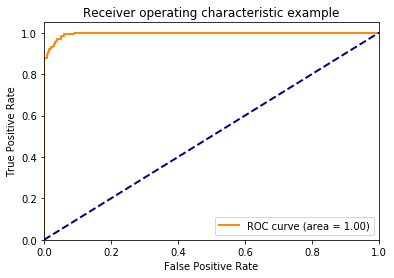

In [110]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()